In [81]:
import re
import pandas as pd

def parse_cd_csv(file_path, temperature_value=None):
    """
    Parses the CD CSV file and dynamically handles 'Temperature' or 'Repeat' columns.
    
    Arguments:
    - file_path: str : Path to the CSV file.
    - temperature_value: float : Required if the structure is based on 'Repeat'. Assigns a constant temperature value for all repeats.
    
    Returns:
    - run_df: DataFrame : Combined and parsed DataFrame from the CSV.
    """
    with open(file_path, "r") as file:
        file_content = file.read()
    
    data_section_match = re.search(r"Data:\n\n(.*)", file_content, re.DOTALL)
    if not data_section_match:
        # Try another common variant if "Data:\n\n" not found
        data_section_match = re.search(r"DATA\s*$", file_content, re.MULTILINE)
        if data_section_match:
            data_section = file_content[data_section_match.end():].strip()
        else:
            raise ValueError("Could not find the data section. Expected 'Data:\\n\\n' or 'DATA'.")
    else:
        data_section = data_section_match.group(1)

    tables_raw = re.split(r'\n\n+', data_section.strip())
    run_df = pd.DataFrame()
    
    # Determine overall file structure (Temperature or Repeat based) from the first valid table
    # This assumes all tables in a file follow the same structure regarding Temperature/Repeat columns.
    file_structure_variable_col_name = None

    for i, section in enumerate(tables_raw):
        if not section.strip(): # Skip empty sections
            continue
        
        match = re.search(r'(CircularDichroism|HV|Absorbance|Voltage|Count|SE)', section)
        if match:
            title = match.group(1)
            lines = section.strip().split('\n')
            
            if len(lines) < 3: # Not enough lines for headers and data
                print(f"Warning: Section '{title}' is too short to parse. Skipping.")
                continue

            variables = lines[1].split(',')
            index_column_name = variables[0]
            assert index_column_name == "Wavelength", "The first column must be 'Wavelength'."
            
            current_section_variable_col_name = variables[1]
            if file_structure_variable_col_name is None:
                file_structure_variable_col_name = current_section_variable_col_name
            elif file_structure_variable_col_name != current_section_variable_col_name:
                raise ValueError(f"Inconsistent variable column types in file: found '{file_structure_variable_col_name}' and '{current_section_variable_col_name}'. All tables must use either Temperature or Repeat.")

            column_headers_str = lines[2].split(',')
            
            data_rows = [line.split(',') for line in lines[3:] if line.strip()]
            if not data_rows:
                print(f"Warning: No data rows found in section '{title}'. Skipping.")
                continue
            
            max_columns = max(len(row) for row in data_rows) # Max columns from data
            # Headers should include Wavelength col + data cols. Data rows should match this.
            # The column_headers_str are for the pivoted values (temps or repeats)
            # The first element of column_headers_str can be empty or a label for Wavelength, ignore it for actual value columns.
            actual_value_column_headers = column_headers_str[1:] 
            
            # Create DataFrame. Header for data columns are taken from column_headers_str[1:]
            # Ensure correct number of column names for pd.DataFrame
            num_data_cols = max_columns -1 # -1 for Wavelength column
            
            df_columns = [index_column_name] + actual_value_column_headers[:num_data_cols]
            if len(df_columns) < max_columns : # Pad if necessary, though data should define width
                 df_columns.extend([f'Unnamed_{j}' for j in range(len(df_columns), max_columns)])


            df = pd.DataFrame(data_rows, columns=df_columns)
            df = df.apply(pd.to_numeric, errors='coerce')
            df = df.reset_index(drop=True)
            df['Wavelength'] = df['Wavelength'].astype(int)
            
            # Melt the table
            df = df.melt(id_vars=["Wavelength"], 
                         var_name=file_structure_variable_col_name, # This will be 'Temperature' or 'Repeat'
                         value_name=title)
            
            # Convert the melted variable column (Temperature or Repeat values) to numeric
            df[file_structure_variable_col_name] = pd.to_numeric(df[file_structure_variable_col_name], errors='coerce')
            df.dropna(subset=[file_structure_variable_col_name], inplace=True) # Drop rows where Temp/Repeat was not numeric (e.g. empty header)

            if run_df.empty:
                run_df = df
            else:
                # Ensure the merge key (Temperature/Repeat column) is present and compatible
                if file_structure_variable_col_name not in run_df.columns:
                     # This case should not happen if all tables are consistent and parsing is correct
                     raise ValueError(f"Merge key '{file_structure_variable_col_name}' not found in accumulated DataFrame.")
                run_df = pd.merge(run_df, df, on=['Wavelength', file_structure_variable_col_name], how='outer',sort=False)
    
    if run_df.empty:
        print("Warning: No data parsed from the file.")
        return pd.DataFrame()

    # Post-processing based on the determined file structure
    if file_structure_variable_col_name == "Temperature":
        assert temperature_value is None, "temperature_value should not be passed when Temperature column is present."
        # Ensure 'Temperature' column is correctly named and typed
        if "Temperature" not in run_df.columns and file_structure_variable_col_name in run_df.columns:
             run_df.rename(columns={file_structure_variable_col_name: "Temperature"}, inplace=True)
        run_df["Temperature"] = pd.to_numeric(run_df["Temperature"], errors='coerce').astype(int)

    elif file_structure_variable_col_name == "Repeat":
        assert temperature_value is not None, "temperature_value must be provided when using 'Repeat' structure."
        run_df["Temperature"] = int(temperature_value) # Assign the constant temperature
        # 'Repeat' column should be numeric; it might be used if not averaging, or for advanced SE calc.
        if "Repeat" not in run_df.columns and file_structure_variable_col_name in run_df.columns:
            run_df.rename(columns={file_structure_variable_col_name: "Repeat"}, inplace=True)
        run_df["Repeat"] = pd.to_numeric(run_df["Repeat"], errors='coerce') # .astype(int) if no NaNs

    else:
        raise ValueError(f"Unknown or undetermined file structure variable: '{file_structure_variable_col_name}'. Expected 'Temperature' or 'Repeat'.")

    # Sort for consistency
    if "Temperature" in run_df.columns:
        sort_cols = ["Temperature", "Wavelength"]
        if "Repeat" in run_df.columns: # If repeats are kept (e.g. not averaged yet)
            sort_cols.append("Repeat")
        run_df = run_df.sort_values(by=sort_cols).reset_index(drop=True)
    else: # Should always have Temperature by now
        run_df = run_df.sort_values(by=["Wavelength"]).reset_index(drop=True)
        
    return run_df


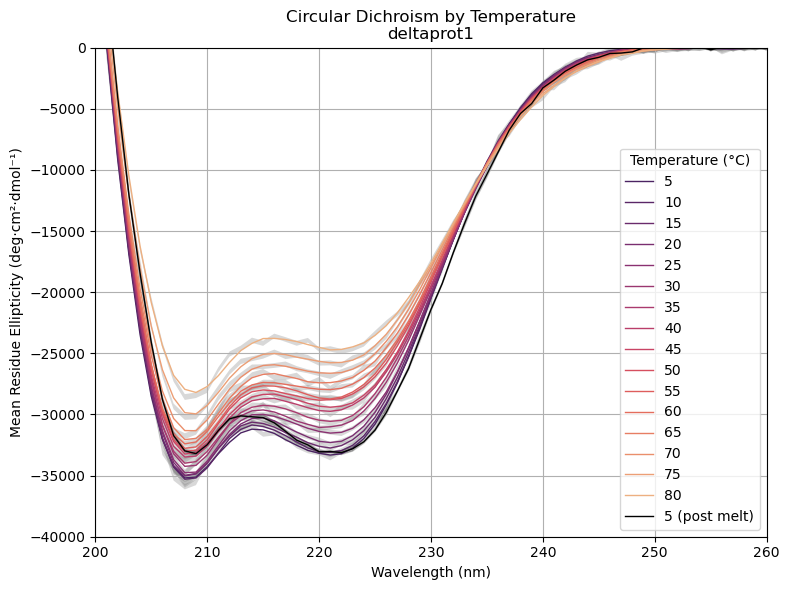

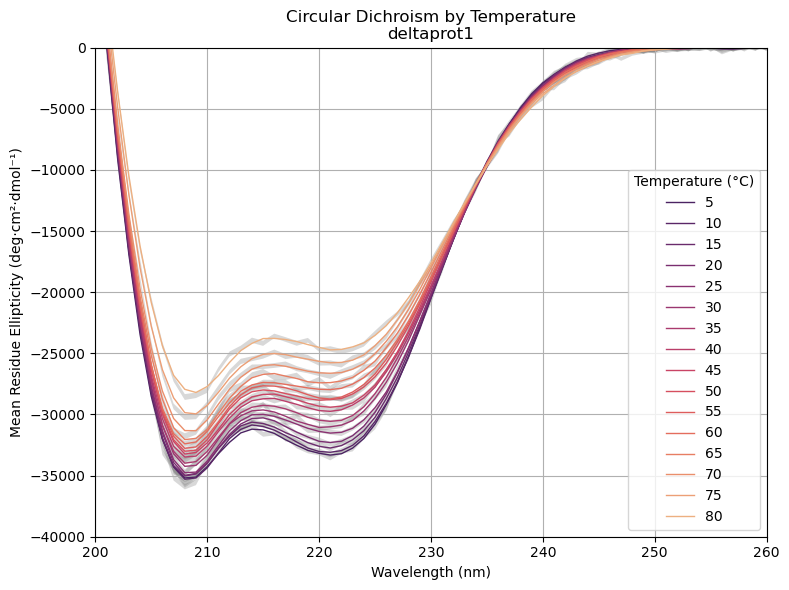

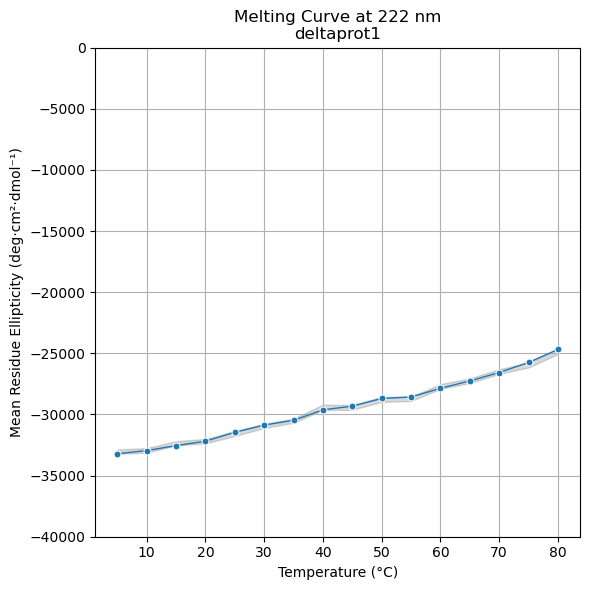

In [84]:
import os
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.signal import savgol_filter


def get_mean_residue_ellipticity(protein_concentration_uM=50, path_length_mm=0.5, num_residues=33):
    # Convert Path Length from mm to cm and Protein Concentration from µM to M
    path_length_cm = path_length_mm / 10  # 1 cm = 10 mm
    concentration_M = protein_concentration_uM * 1e-6  # Convert µM to M
    # Calculate MRE multiplication factor
    return 1 / (10 * path_length_cm * num_residues * concentration_M)

def smooth_cd_data(cd_data, column_name='CircularDichroism', window_length=10, polyorder=2):
    """
    Smooth the CD data using the Savitzky-Golay filter.

    Parameters:
    - cd_data: DataFrame containing the CD data.
    - column_name: Name of the column to smooth.
    - window_length: The length of the filter window (i.e., the number of coefficients). Must be a positive odd integer.
    - polyorder: The order of the polynomial used to fit the samples. Must be less than window_length.

    Returns:
    - Smoothed data as a NumPy array.
    """
    # Ensure window_length is odd and less than or equal to the size of the data
    if window_length % 2 == 0:
        window_length += 1
    if window_length > len(cd_data):
        window_length = len(cd_data) - (len(cd_data) % 2 == 0)

    y = cd_data[column_name].values
    smoothed = savgol_filter(y, window_length=window_length, polyorder=polyorder, mode='interp')
    return smoothed

def prepare_cd_data(cd_data, protein_concentration_uM=50, path_length_mm=0.5, num_residues=33):
    mre_factor = get_mean_residue_ellipticity(protein_concentration_uM, path_length_mm, num_residues)
    cd_data['Smoothed_CD'] = smooth_cd_data(cd_data, column_name='CircularDichroism')
    cd_data['MRE_deg_cm2_dmol'] = cd_data['CircularDichroism'] * mre_factor
    cd_data['Smoothed_MRE_deg_cm2_dmol'] = cd_data['Smoothed_CD'] * mre_factor
    cd_data['SE_MRE_deg_cm2_dmol'] = cd_data['SE'] * mre_factor
    return cd_data


def plot_cd_melt(cd_filtered, label_suffix='', line_width=1):
    sns.lineplot(
        data=cd_filtered,
        x='Wavelength',
        y='Smoothed_MRE_deg_cm2_dmol',
        hue='Temperature',
        palette='flare_r',
        linewidth=line_width,
        legend='full',
        sort=False
    )

    for temp, grp in cd_filtered.groupby('Temperature'):
        grp = grp.sort_values('Wavelength')
        plt.fill_between(
            grp['Wavelength'],
            grp['MRE_deg_cm2_dmol'] - grp['SE_MRE_deg_cm2_dmol'],
            grp['MRE_deg_cm2_dmol'] + grp['SE_MRE_deg_cm2_dmol'],
            alpha=0.3,
            color="grey",
            edgecolor=None
        )

def plot_cd_melt_data(cd_data, sample_name, overlay_cd_data=None, overlay_label="Overlay",
                      title="Circular Dichroism by Temperature", save_dir="."):
    # Prepare CD data
    cd_data = prepare_cd_data(cd_data)

    # Set limits for the plot
    x_limits = (200, 260)
    y_limits = (-40000, 1)

    # Filter the data for the relevant wavelength range
    cd_filtered = cd_data[(cd_data['Wavelength'] >= x_limits[0]) & (cd_data['Wavelength'] <= x_limits[1])]

    # Plot the data
    plt.figure(figsize=(8, 6))
    plot_cd_melt(cd_filtered, line_width=1)  # Use a thinner line

    # Check if there is overlay data to plot
    if overlay_cd_data is not None:
        overlay_cd_data = prepare_cd_data(overlay_cd_data)
        overlay_cd_filtered = overlay_cd_data[(overlay_cd_data['Wavelength'] >= x_limits[0]) & 
                                              (overlay_cd_data['Wavelength'] <= x_limits[1])]
        
        sns.lineplot(
            data=overlay_cd_filtered,
            x='Wavelength',
            y='MRE_deg_cm2_dmol',
            color='black',
            label=f'{overlay_label}',
            linewidth=1,
        )



    # Customize the plot
    title+=f"\n{sample_name}"
    plt.title(title)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel("Mean Residue Ellipticity (deg·cm²·dmol⁻¹)")
    plt.xlim(x_limits)
    plt.ylim(y_limits)
    plt.grid(True)
    plt.legend(title='Temperature (°C)', loc='best')

    # Save the plot
    filename = f"cd_melts_{sample_name}"
    if overlay_cd_data is not None:
        filename += "_overlay"
    for ext in ["png", "svg"]:
        plt.savefig(os.path.join(save_dir, f"{filename}.{ext}"), dpi=300, bbox_inches="tight")

    plt.tight_layout()
    plt.show()

# Example call to plotting function

def plot_melting_curve(cd_data, sample_name, title="Melting Curve at 222 nm", save_dir="."):
    # Prepare data
    cd_data = prepare_cd_data(cd_data)

    # Filter the data for Wavelength = 222 nm
    melting_data = cd_data[cd_data['Wavelength'] == 222.0]

    # Set up the plot for the melting curve
    plt.figure(figsize=(6, 6))
    # Plot the error area using fill_between
    
    plt.fill_between(melting_data['Temperature'],
                     melting_data['MRE_deg_cm2_dmol'] - melting_data['SE_MRE_deg_cm2_dmol'],
                     melting_data['MRE_deg_cm2_dmol'] + melting_data['SE_MRE_deg_cm2_dmol'],
                     alpha=0.3,edgecolor=None,color='grey')  # Transparency for the shaded error area
    sns.lineplot(data=melting_data, x='Temperature', y='Smoothed_MRE_deg_cm2_dmol', marker='o', linewidth=1, markersize=5, legend=False,)  # Thinner line, smaller markers



    # Customize the plot
    title+=f"\n{sample_name}"
    plt.title(title)
    plt.xlabel('Temperature (°C)')
    plt.ylabel("Mean Residue Ellipticity (deg·cm²·dmol⁻¹)")
    plt.grid(True)
    plt.tight_layout()

    y_limits = (-40000, 1)
    plt.ylim(y_limits)

    # Save the plot
    for ext in ["png", "svg"]:
        plt.savefig(os.path.join(save_dir, f"melting_curve_{sample_name}.{ext}"), dpi=300, bbox_inches="tight")

    plt.show()

melt_df = parse_cd_csv(
    "/home/tadas/code/CD_analysis/inputs/glasgow_cd/deltaprot1_50uM_5C_80Cmelt00002.csv"
)
post_melt_df = parse_cd_csv("/home/tadas/code/CD_analysis/inputs/glasgow_cd/deltaprot1_50uM_5C_postmelt00000.csv",temperature_value=5)
plot_cd_melt_data(melt_df, sample_name="deltaprot1", overlay_label="5 (post melt)", overlay_cd_data=post_melt_df,save_dir="/home/tadas/code/CD_analysis/outputs/glasgow_cd")
plot_cd_melt_data(melt_df, sample_name="deltaprot1",save_dir="/home/tadas/code/CD_analysis/outputs/glasgow_cd")
plot_melting_curve(melt_df, sample_name="deltaprot1",save_dir="/home/tadas/code/CD_analysis/outputs/glasgow_cd")